In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.signal as signal
from scipy import fftpack
import Analysis_Modules as am
import pandas as pd

In [2]:
# データファイルを読み込み
files = glob.glob("../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/*")
files = sorted(files)
for i,file in enumerate(files):
    print(i+1,file)

1 ../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/20220811.183700.raw
2 ../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/20220811.183732.raw
3 ../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/20220811.183805.raw
4 ../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/20220811.183838.raw
5 ../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/20220811.183911.raw
6 ../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/20220811.183943.raw
7 ../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/20220811.184016.raw
8 ../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/20220811.184049.raw
9 ../../Signal/Observation_Signal_Log/20220811_seikogiken/RawData_20220811/useful_data/20220811.184122.raw
10 ../../Signal/Observation_Signal_Lo

In [3]:
MU_SIG = am.signal_muradar(signal_filepath=files[0:20])

===== MU radar observation data check  =====
raw data shape:      (5, 26, 100, 20480)
subarray modules:    ['A01' 'A02' 'A03' 'A04' 'B01' 'B02' 'B03' 'B04' 'C01' 'C02' 'C03' 'C04'
 'D01' 'D02' 'D03' 'D04' 'E01' 'E02' 'E03' 'E04' 'F01' 'F02' 'F03' 'F04'
 'F05']




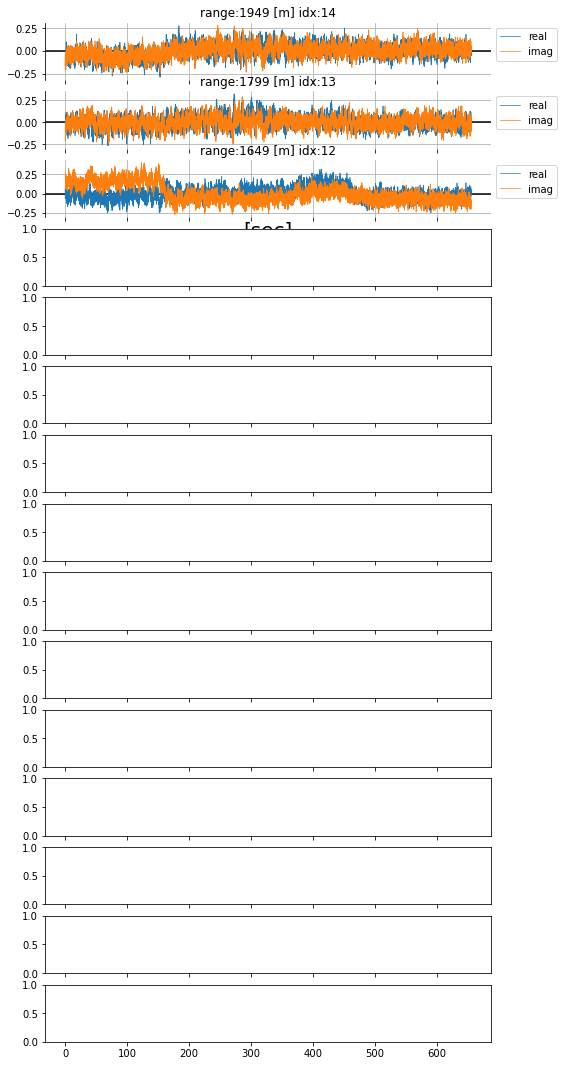

In [93]:
beam_direc = 2 #ビーム方向
channel = 26 #受信チャンネル番号
col = 15
# 時間領域解析
time = MU_SIG.dt*np.arange(MU_SIG.raw.shape[3])
radar_range = MU_SIG.radar_range
time_data = np.zeros((col,time.size),dtype=complex)
time_data_avg = np.zeros_like(time_data)

fig, ax = plt.subplots(col,1, figsize=(8,(col)*1.25),sharex=True)
for idx in range(col):
    time_data[col-idx-1,:] = MU_SIG.raw[beam_direc,channel-1,col-idx-1,:]
    time_data_avg[col-idx-1,:] = time_data[col-idx-1,:] - np.average(time_data[col-idx-1,:])
    ax[idx].axhline(0, color="black")
    ax[idx].plot(time, time_data_avg[col-idx-1,:].real, linewidth=0.7, label="real")
    ax[idx].plot(time, time_data_avg[col-idx-1,:].imag, linewidth=0.7, label="imag")
#     ax[idx].plot(time, np.abs(time_data_avg[col-idx-1,:]), linewidth=0.7, label="abs")
    ax[idx].set_title("range:{:.0f} [m] idx:{}".format(radar_range[col-idx-1],col-idx-1))
    ax[idx].spines["right"].set_color("none")  # 右消し
    ax[idx].spines["top"].set_color("none")    # 上消し
    ax[idx].spines["bottom"].set_color("none") # 下消し
    ax[idx].grid()
    ax[idx].legend(bbox_to_anchor=(1,1), loc="upper left")
    if idx==2:
        break
ax[idx].set_xlabel("[sec]",fontsize=20)
plt.show()

In [94]:
# 周波数領域解析
n = int(60/MU_SIG.dt) #nはサンプリング点数
incoherent_times = int(MU_SIG.raw.shape[3]/n)
freqs = fftpack.fftfreq(n=n, d=MU_SIG.dt)
dvel = fftpack.fftshift(freqs*MU_SIG.lamda/2)
dvel0 = np.delete(dvel,int(n/2))
power = np.zeros((col,n))
power0 = np.zeros((col, n-1))
for idx in range(col):  # レンジのループ
    for l in range(incoherent_times):
        power[idx,:] = power[idx,:] + np.abs(fftpack.fft(time_data[idx,n*l:n*(l+1)]))**2
    power[idx,:] = fftpack.fftshift(power[idx,:],0)
    power0[idx,:] = np.delete(power[idx,:],int(n/2))

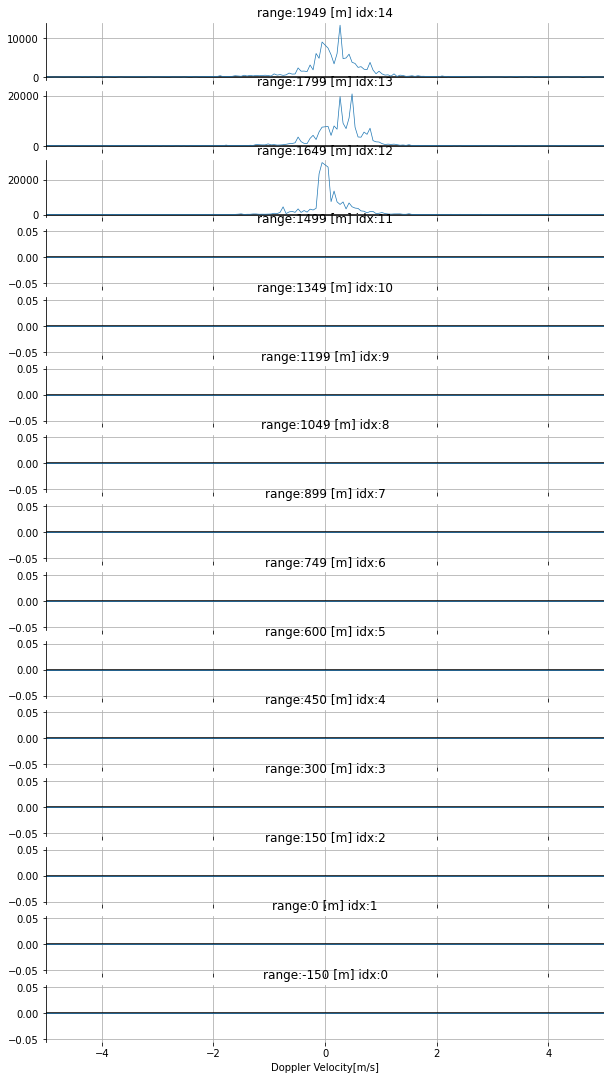

In [96]:
fig, ax = plt.subplots(col,1, figsize=(10,col*1.25),sharex=True)
for idx in range(col):
    ax[idx].axhline(0, color="black")
    ax[idx].plot(dvel0, power0[col-idx-1,:], linewidth=0.7)
#     ax[idx].plot(dvel, power[col-idx-1,:], linewidth=0.7, label="imag")
    ax[idx].set_title("range:{:.0f} [m] idx:{}".format(radar_range[col-idx-1],col-idx-1))
    ax[idx].spines["right"].set_color("none")  # 右消し
    ax[idx].spines["top"].set_color("none")    # 上消し
    ax[idx].spines["bottom"].set_color("none") # 下消し
    ax[idx].set_xlim(-5,5)
    ax[idx].grid()
#     if idx==2:
#         break
#     ax[idx].legend(bbox_to_anchor=(1,1), loc="upper left")
ax[idx].set_xlabel("Doppler Velocity[m/s]")
plt.show()

In [59]:
index_sinecho = np.argmax(power0[7,:])
index_clutter = np.argmax(power[4,:])
print("謎の正弦波エコーindex:{}".format(index_sinecho))
print("クラッターエコーindex:{}".format(index_clutter))

謎の正弦波エコーindex:932
クラッターエコーindex:937


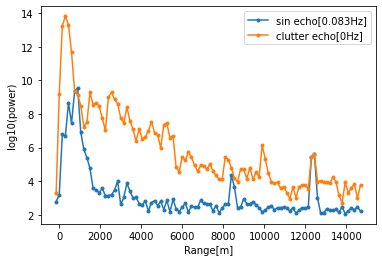

In [63]:
plt.plot(radar_range[0:col],np.log10(power0[:,index_sinecho]),label="sin echo[0.083Hz]",marker='.')
plt.plot(radar_range[0:col],np.log10(power[:,index_clutter]),label="clutter echo[0Hz]",marker='.')
plt.xlabel("Range[m]")
plt.ylabel("log10(power)")
plt.legend()
# plt.ylim(0,1e3)